In [80]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

DATA_DIR = Path("./Datasets")

X = np.load(DATA_DIR / "kryptonite-20-X.npy")
y = np.load(DATA_DIR / "kryptonite-20-y.npy")

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("First 5 labels:", y[:5])

df = pd.DataFrame(X, columns=[f"x{i+1}" for i in range(X.shape[1])])
df["label"] = y
df.head()


Shape of X: (40000, 20)
Shape of y: (40000,)
First 5 labels: [0 1 0 1 1]


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,label
0,-0.092816,0.000573,0.953260,0.013263,0.939400,0.903328,1.025891,1.077291,0.041983,0.995213,...,0.053393,-0.087396,-0.029154,0.918305,0.018494,-0.061797,0.005953,0.104635,0.139689,0
1,0.917080,-0.122235,0.135909,1.015742,0.895067,0.015847,1.283686,0.162562,0.909719,0.116698,...,0.796576,0.107156,0.156603,0.959109,0.033873,0.019167,-0.226060,0.993300,1.073230,1
2,0.146643,1.222343,0.067754,0.890514,0.180961,0.163919,-0.193633,1.082385,-0.101428,0.944445,...,0.019588,0.975359,-0.169063,1.121547,1.007832,-0.049673,0.048414,0.997840,0.065810,0
3,0.046387,-0.042996,0.144603,1.100785,0.940041,0.916524,1.047655,0.068312,-0.093637,-0.096154,...,-0.028926,0.971487,0.061131,0.961669,-0.147159,0.112188,0.051860,0.037339,0.791753,1
4,-0.049342,0.179119,-0.272280,0.993542,0.860185,1.145050,0.013814,0.920854,0.109026,0.914044,...,1.035649,0.039938,-0.111463,1.205844,0.898251,1.148852,0.103803,1.053580,0.782019,1


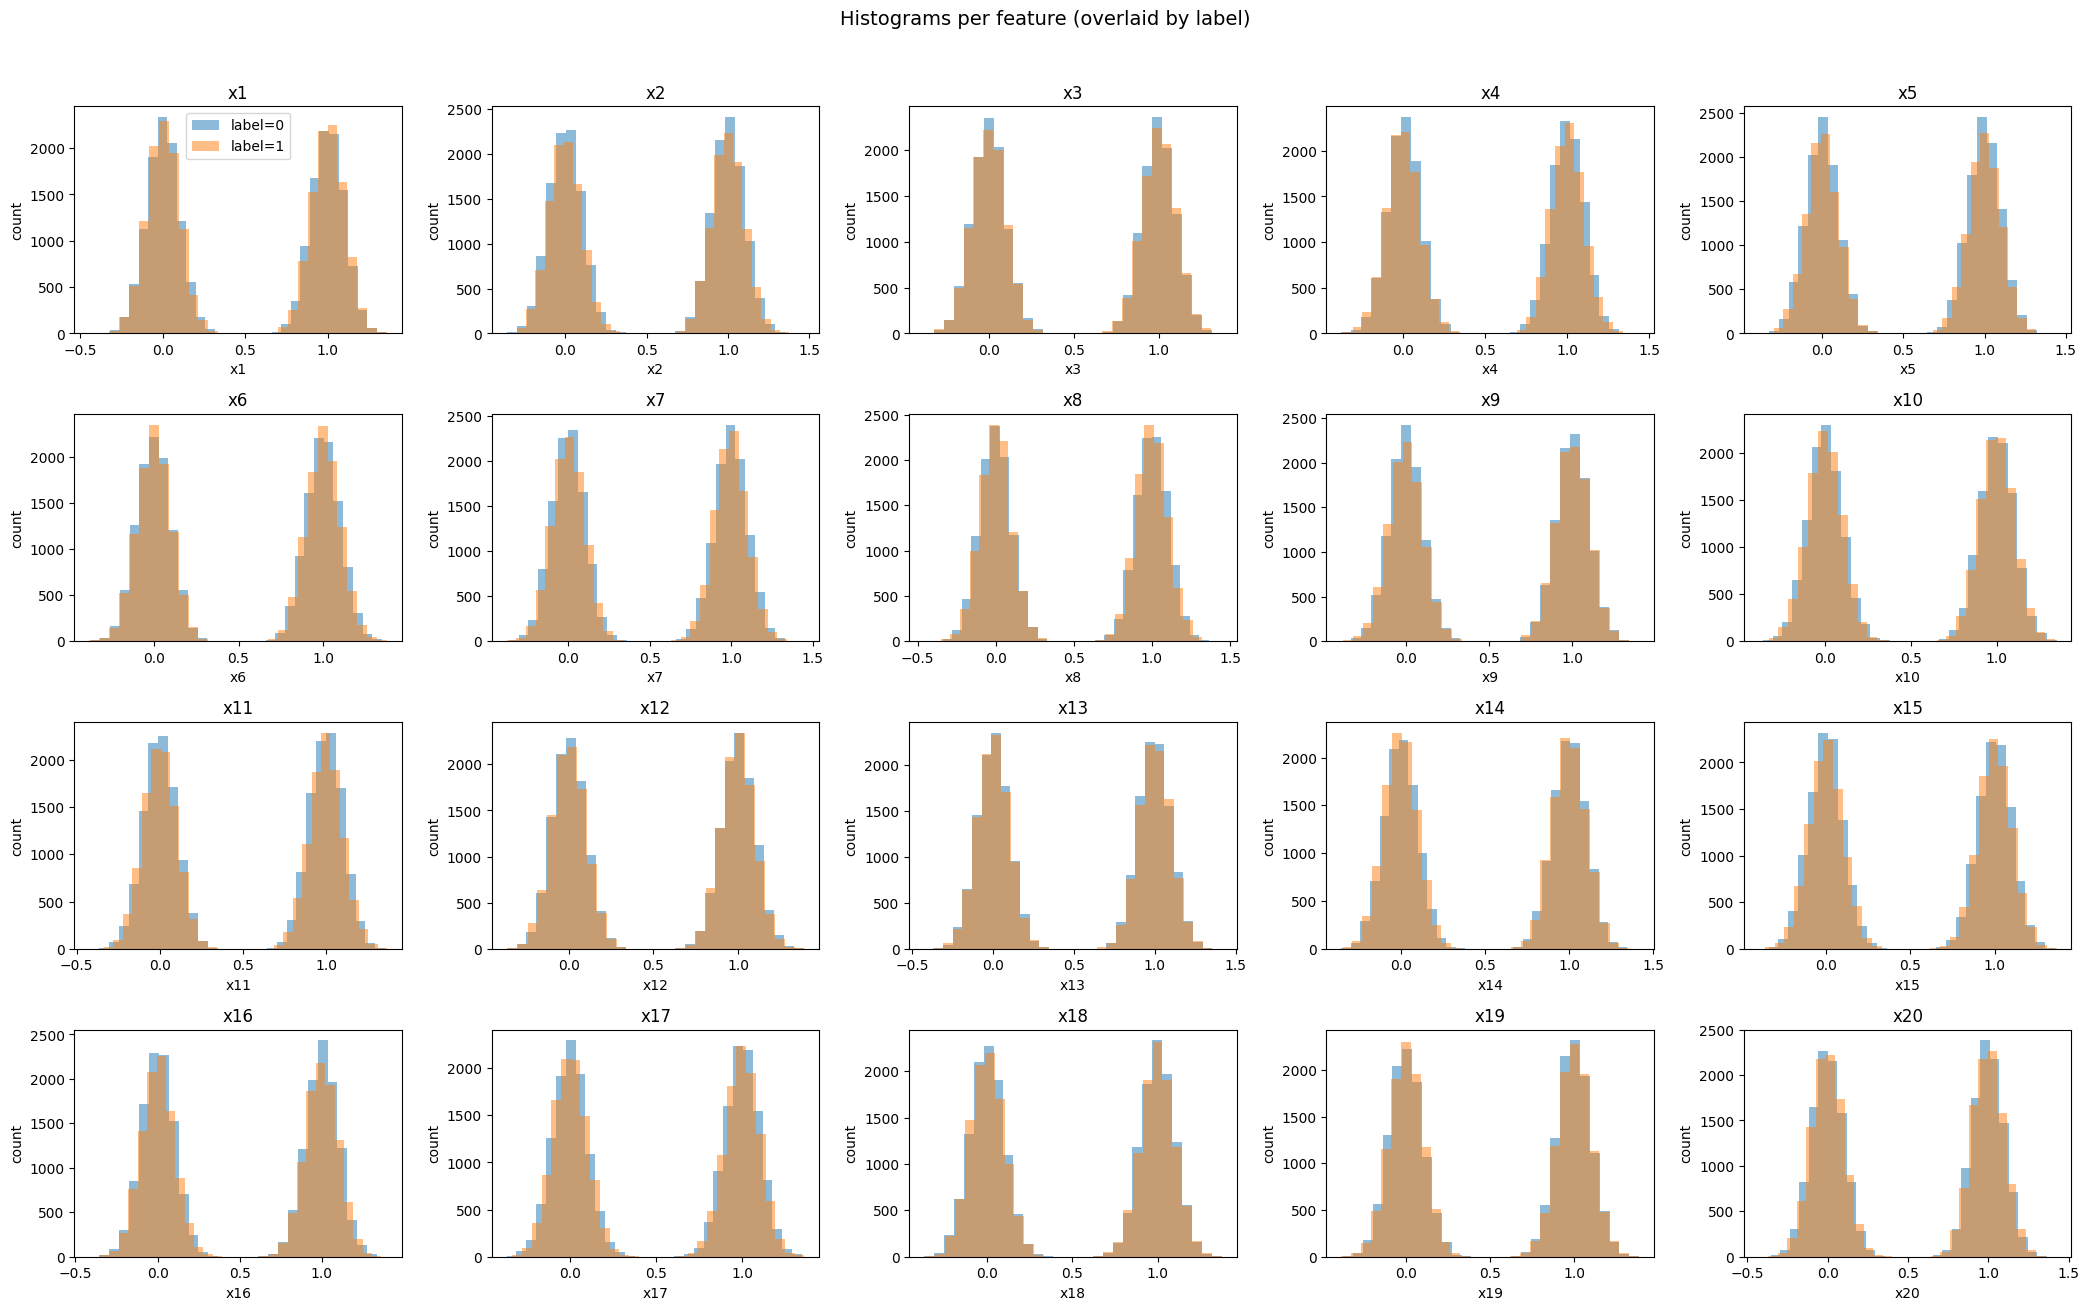

In [ ]:
# ==========================================
# 1) Histogram
# ==========================================
import math

features = [c for c in df.columns if c != "label"]
n_feat = len(features)

cols = 5
rows = math.ceil(n_feat / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.2, rows*3.2))
axes = axes.ravel()

for i, f in enumerate(features):
    ax = axes[i]
    # class 0
    ax.hist(df.loc[df["label"]==0, f], bins=30, alpha=0.5, label="label=0")
    # class 1
    ax.hist(df.loc[df["label"]==1, f], bins=30, alpha=0.5, label="label=1")
    ax.set_title(f)
    ax.set_xlabel(f)
    ax.set_ylabel("count")
    if i == 0:
        ax.legend()

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Histograms per feature (overlaid by label)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


# Histogram analysis
In the histogram analysis, the distributions of the two classes almost completely overlap across most features (the colored regions are nearly identical).  

This indicates that the distributions of label = 0 and label = 1 are nearly the same, meaning that no single feature alone can distinguish between the two classes.

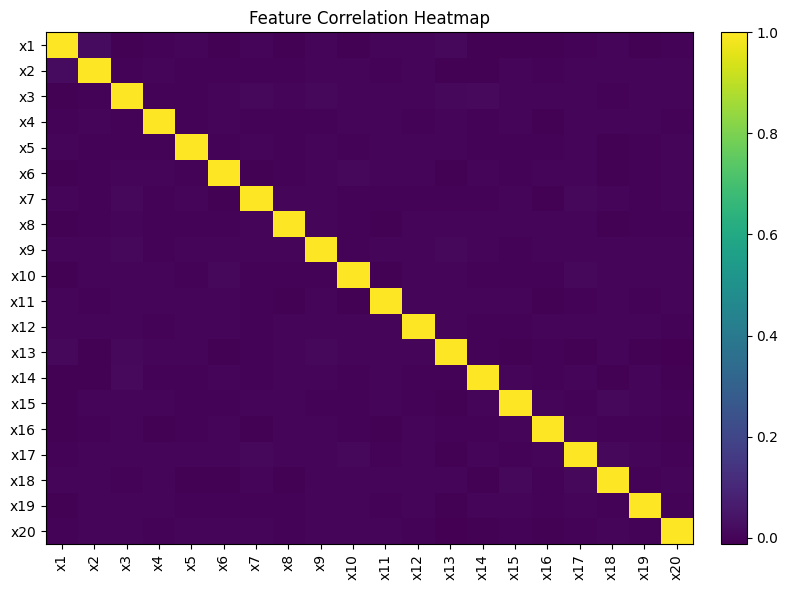

In [ ]:
# ==========================================
# 2) Heatmap
# # ==========================================
feat_only = df[features]
corr = feat_only.corr()  

plt.figure(figsize=(8,6))
im = plt.imshow(corr.values, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(n_feat), features, rotation=90)
plt.yticks(range(n_feat), features)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# Heatmap
In the correlation heatmap, all off-diagonal cells appear close to zero (dark purple), indicating that there is almost no correlation between features.  

| Observation                                           | Interpretation                                             | Implication                                                                                           |
| ----------------------------------------------------- | ---------------------------------------------------------- | ----------------------------------------------------------------------------------------------------- |
| All features are independent (correlation ≈ 0)        | Features are largely unrelated to each other               | 1. Dimensionality reduction (e.g., PCA) provides little benefit.<br>2. No redundant features to remove. |
| Features are uncorrelated, and labels are also mixed  | Each feature alone carries no signal about the label       | 3. The label is likely embedded in **nonlinear combinations or interactions** among multiple features. |


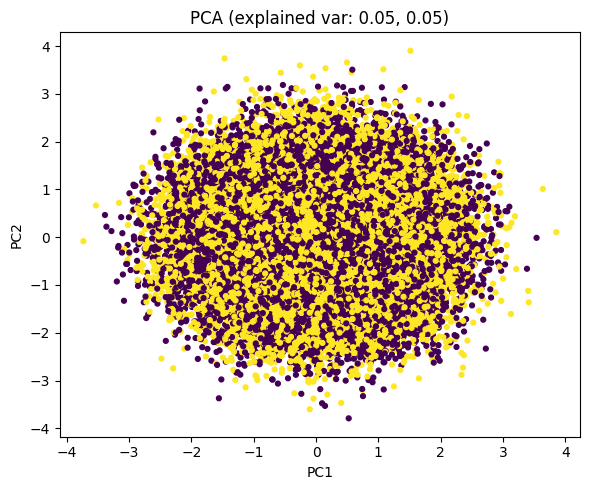

In [ ]:
# ==========================================
# 3) PCA
# ==========================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feat_only.values)

# ---- PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["label"].values, s=12)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA (explained var: {pca.explained_variance_ratio_[0]:.2f}, {pca.explained_variance_ratio_[1]:.2f})")
plt.tight_layout()
plt.show()

# PCA
No clear clusters, bands, or boundaries are observed.  

This dataset exhibits no apparent linear structure.
Therefore, linear models such as Logistic Regression or Linear SVM are likely to fail in distinguishing between the labels.

# Different Machine Learning Models

Different Machine Learning Models In this
work, we primarily examined the performance of logistic
regression for our binary classification task. While logistic
regression is well-suited for linearly separable data, it may
be suboptimal for complex patterns. Future studies could
**explore alternative models, such as neural networks, which
are known for their capacity to capture intricate, non-linear
relationships through deep representations.** Additionally,
**tree-based models** or **clustering-based approaches** could pro-
vide a richer structure for capturing decision boundaries,
especially in scenarios where the dataset presents high vari-
ance or multiple classes. Comparative analysis across these
models could yield valuable insights into the trade-offs in
accuracy, interpretability, and computational efficiency.

In [ ]:
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier

features = [c for c in df.columns if c != "label"]
X = df[features].values
y = df["label"].values

# You can use naive cv but I just used stratified cv for better practice (you can change to naive one if you want)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_cv(model, X, y, name):
    acc = cross_val_score(model, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
    print(f"Accuracy: {acc.mean():.4f} ± {acc.std():.4f}")
    return {"Model": name, "Acc_Mean": acc.mean(), "Acc_Std": acc.std()}


In [ ]:
# --- Logistic Regression ---
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=500, solver="lbfgs"))
])

res_logreg = evaluate_cv(logreg, X, y, "LogisticRegression")


Accuracy: 0.4997 ± 0.0040


In [ ]:
# --- SVM (RBF) ---
svm_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf"))
])

res_svm = evaluate_cv(svm_rbf, X, y, "SVM (RBF)")


Accuracy: 0.5001 ± 0.0019


The phrase **“capture intricate, non-linear relationships”** explicitly implies the use of an **MLP (Multi-Layer Perceptron)** or other neural network models, which are designed to model complex, nonlinear patterns through layered representations.

Applied two differrent algorithms to MLP (SGD and ADAM)  

SGD (Stochastic Gradient Descent) updates parameters based only on the current gradient, while
Adam (Adaptive Moment Estimation) combines momentum and adaptive learning rates, making optimization faster and more stable.


In [ ]:
# --- MLP (SGD) ---
mlp_sgd = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(128,64),
                          activation="relu",
                          solver="sgd",
                          learning_rate_init=1e-3,
                          momentum=0.9, # optional but makes training faster and stabler
                          max_iter=300,
                          early_stopping=True,
                          random_state=42))
])

res_mlp_sgd = evaluate_cv(mlp_sgd, X, y, "MLP (SGD)")

Accuracy: 0.5066 ± 0.0056


In [ ]:
# --- MLP (Adam) ---
mlp_adam = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(128,64),
                          activation="relu",
                          solver="adam",
                          learning_rate_init=1e-3,
                          max_iter=300,
                          early_stopping=True,
                          random_state=42))
])

res_mlp_adam = evaluate_cv(mlp_adam, X, y, "MLP (Adam)")


Accuracy: 0.8122 ± 0.0294


There is a phrase “tree-based models could provide richer structure for capturing decision boundaries” from pdf. 

I only tried RandomForest here since i keep getting an error when i run xgboost


In [ ]:
# --- RandomForest ---
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

res_rf = evaluate_cv(rf, X, y, "RandomForest")


Accuracy: 0.5026 ± 0.0026


In [ ]:
# # ---  XGBoost ---
# xgb = XGBClassifier(
#     n_estimators=800,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     eval_metric="logloss",
#     use_label_encoder=False
# )

# res_xgb = evaluate_cv(xgb, X, y, "XGBoost")


In [94]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(
    criterion="gini",             # or "entropy"
    max_depth=None,               
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

res_tree = evaluate_cv(tree, X, y, "Decision Tree (Gini)")

Accuracy: 0.4989 ± 0.0089


Cluster Based

In [97]:
# --- KNN ---
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors
knn = Pipeline([
    ("scaler", StandardScaler()),  
    ("knn", KNeighborsClassifier(
        n_neighbors=5,             
        weights="distance",        
        metric="minkowski",     
        n_jobs=-1
    ))
])

res_knn  = evaluate_cv(knn,  X, y, "KNN (k=5)")


Accuracy: 0.4761 ± 0.0034


# Result

In [98]:
results = [
    res_logreg, res_svm,
    res_mlp_sgd, res_mlp_adam,
    res_rf, res_knn, res_tree
]
res_df = pd.DataFrame(results).sort_values("Acc_Mean", ascending=False).reset_index(drop=True)
display(res_df)

# Save to CSV
res_df.to_csv("model_cv_summary_20.csv", index=False)
print("Saved: model_cv_summary.csv")


,Model,Acc_Mean,Acc_Std
0,MLP (Adam),0.812200,0.029383
1,MLP (SGD),0.506575,0.005605
2,RandomForest,0.502600,0.002561
3,SVM (RBF),0.500075,0.001875
4,LogisticRegression,0.499750,0.004040
5,Decision Tree (Gini),0.498875,0.008884
6,KNN (k=5),0.476075,0.003410


Saved: model_cv_summary.csv
